# Set Up

## Mount Google Drive

Ignore if not using Google Collab:

In [1]:
from google.colab import drive

# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/cooling_with_code.git
%cd cooling_with_code
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'cooling_with_code' already exists and is not an empty directory.
/content/drive/My Drive/cooling_with_code
Already up to date.


## Import Libraries

In [2]:
%pip install smogn imbalanced-learn

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#data science
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
import smogn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#custom tools
from tools.environment import VALID_SPLIT, RANDOM_STATE
from tools.feature_selection import load_and_prepare_data
from tools.outlier import univariate_outlier_analysis
from tools.distribution import plot_all_histograms

## Import Datasets

In [4]:
#load in datasets
raw = pd.read_csv('data/train/150m_buffer_dataset.csv')

# Helper Functions

In [5]:
def apply_winsorization(df, limits=(0.01, 0.01)):
    """
    Apply Winsorization to all numerical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The dataset containing numerical features.
        limits (tuple): The lower and upper quantile limits for Winsorization.

    Returns:
        pd.DataFrame: The Winsorized dataset.
    """
    df_winsorized = df.copy()  # Create a copy to avoid modifying original data

    # Apply Winsorization to all numeric columns
    for col in df_winsorized.select_dtypes(include=['number']).columns:
        df_winsorized[col] = winsorize(df_winsorized[col], limits=limits)

    return df_winsorized

In [6]:
def apply_boxcox_transformation(df, threshold, exclude_cols=[]):
    """
    Apply Box-Cox transformation to specified DataFrame based on skew threshold.

    Parameters:
        df (pd.DataFrame): The dataset containing numerical features.
        threshold (float): The absolute value of the skew threshold.
        exclude_cols (list): List of column names to exclude from transformation.

    Returns:
        pd.DataFrame: The dataset with Box-Cox transformed columns.
    """
    df_transformed = df.copy()  # Create a copy to avoid modifying original data

    # get cols to apply transformation
    boxcox_cols = [col for col in df_transformed.columns if abs(skew(df_transformed[col])) > threshold]
    if exclude_cols:
        boxcox_cols = [col for col in boxcox_cols if col not in exclude_cols]

    for col in boxcox_cols:
        # Ensure all values are positive before applying Box-Cox
        if (df_transformed[col] <= 0).any():
            df_transformed[col] += abs(df_transformed[col].min()) + 1  # Shift to positive

        # Apply Box-Cox transformation
        df_transformed[col], _ = boxcox(df_transformed[col])

    return df_transformed

# Preprocessing

This notebook is for applying what we learned in [04_EDA](/04_EDA.ipynb) to our dataset. For details on the train/test dataset refer to our past notebooks:
- [01_dataset_generation](/01_dataset_generation.ipynb)
- [02_more_dataset_generation](/02_more_dataset_generation.ipynb)

Like stated in [04_EDA](/04_EDA.ipynb) we will only move forward with 150m Buffer dataset.

>NOTE: Most of the discovery was done in [04_EDA](/04_EDA.ipynb). This notebook will be more about applying the solutions.

In [25]:
#copy dataset, for editing
dataset = raw.copy()

## Eliminating Outliers

First, we will eliminate outliers. To do this we will use Winsorization. This preserves data size while reducing outlier influence by replacing outliers with the nearest valid value. First, lets plot the data before eliminating outliers.

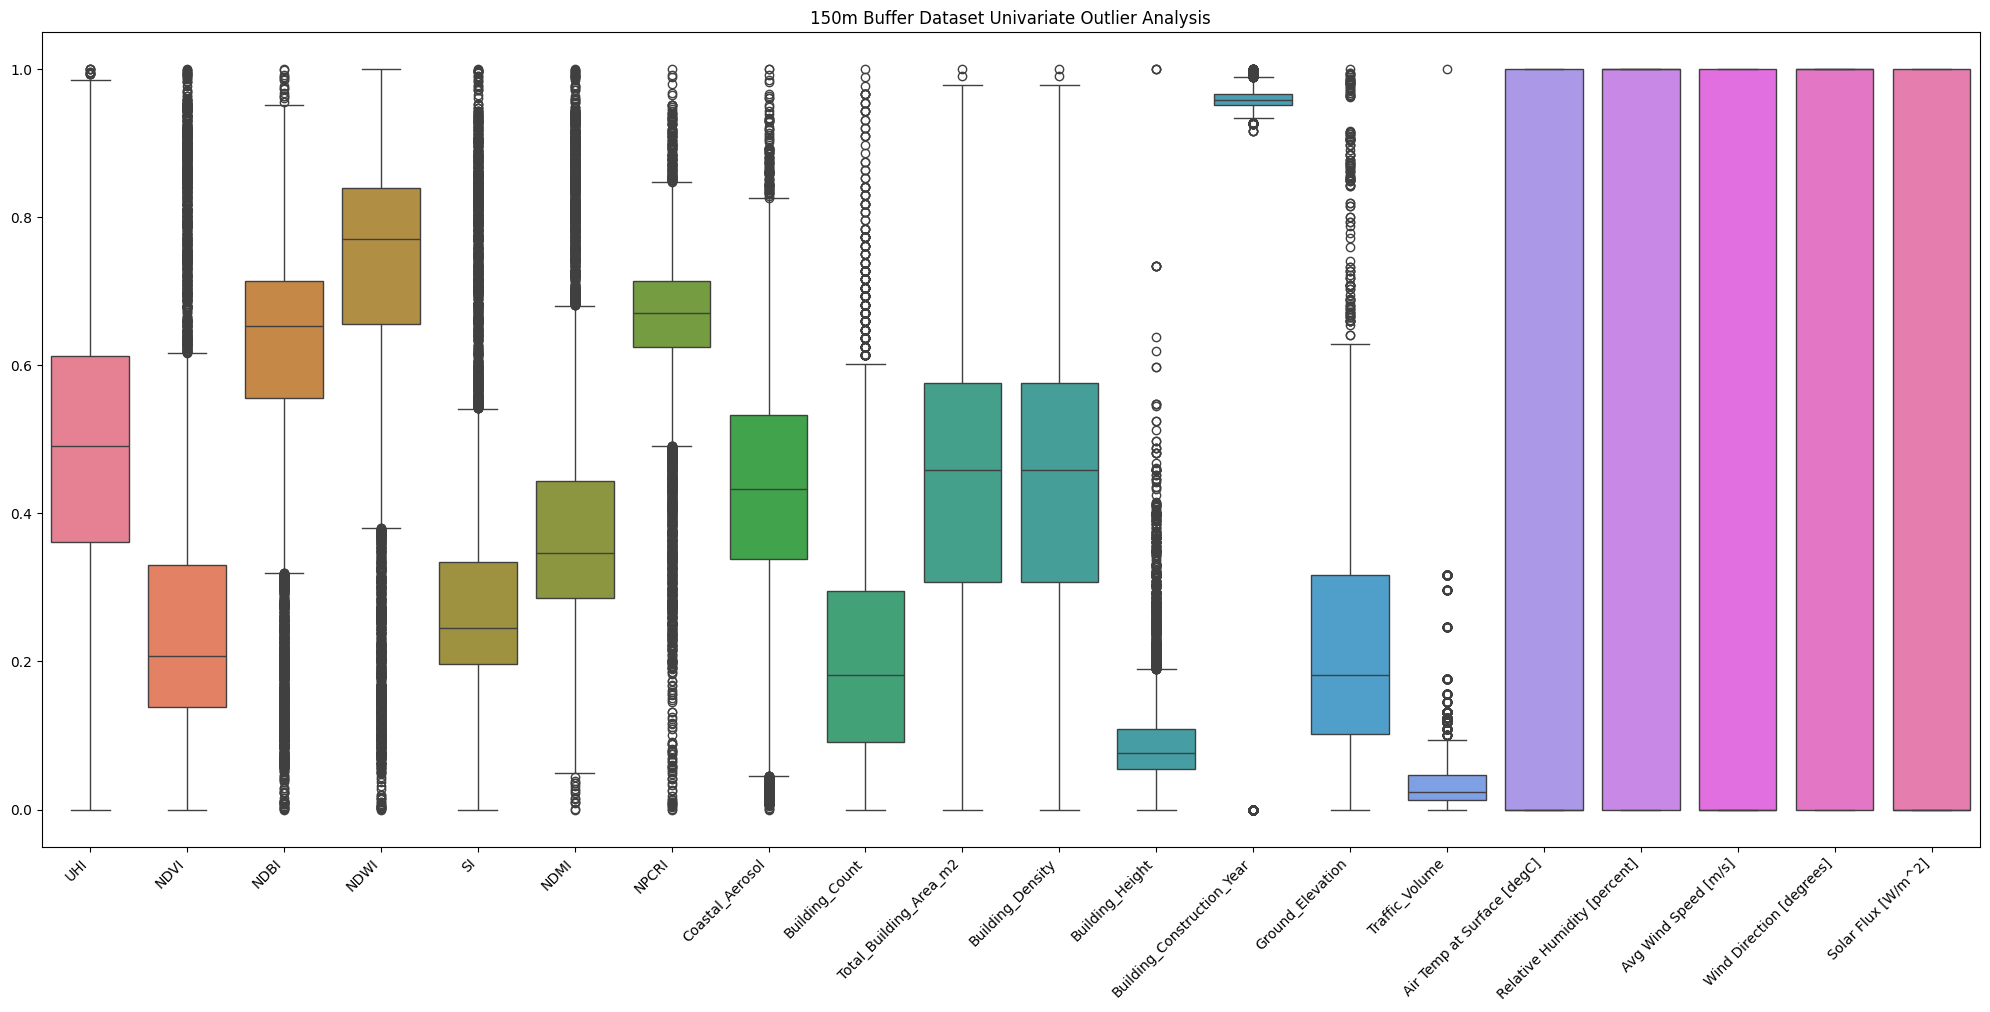

In [8]:
univariate_outlier_analysis(dataset, "150m Buffer Dataset")

Now, lets eliminate outliers

In [22]:
# we won't apply the transformation on target variable
uhi = dataset.pop('UHI')
dataset = apply_winsorization(dataset,(0.03, 0.03))  # Cap bottom/top 3%
dataset['UHI'] = uhi

Finally, we will plot the data again to see the effect.

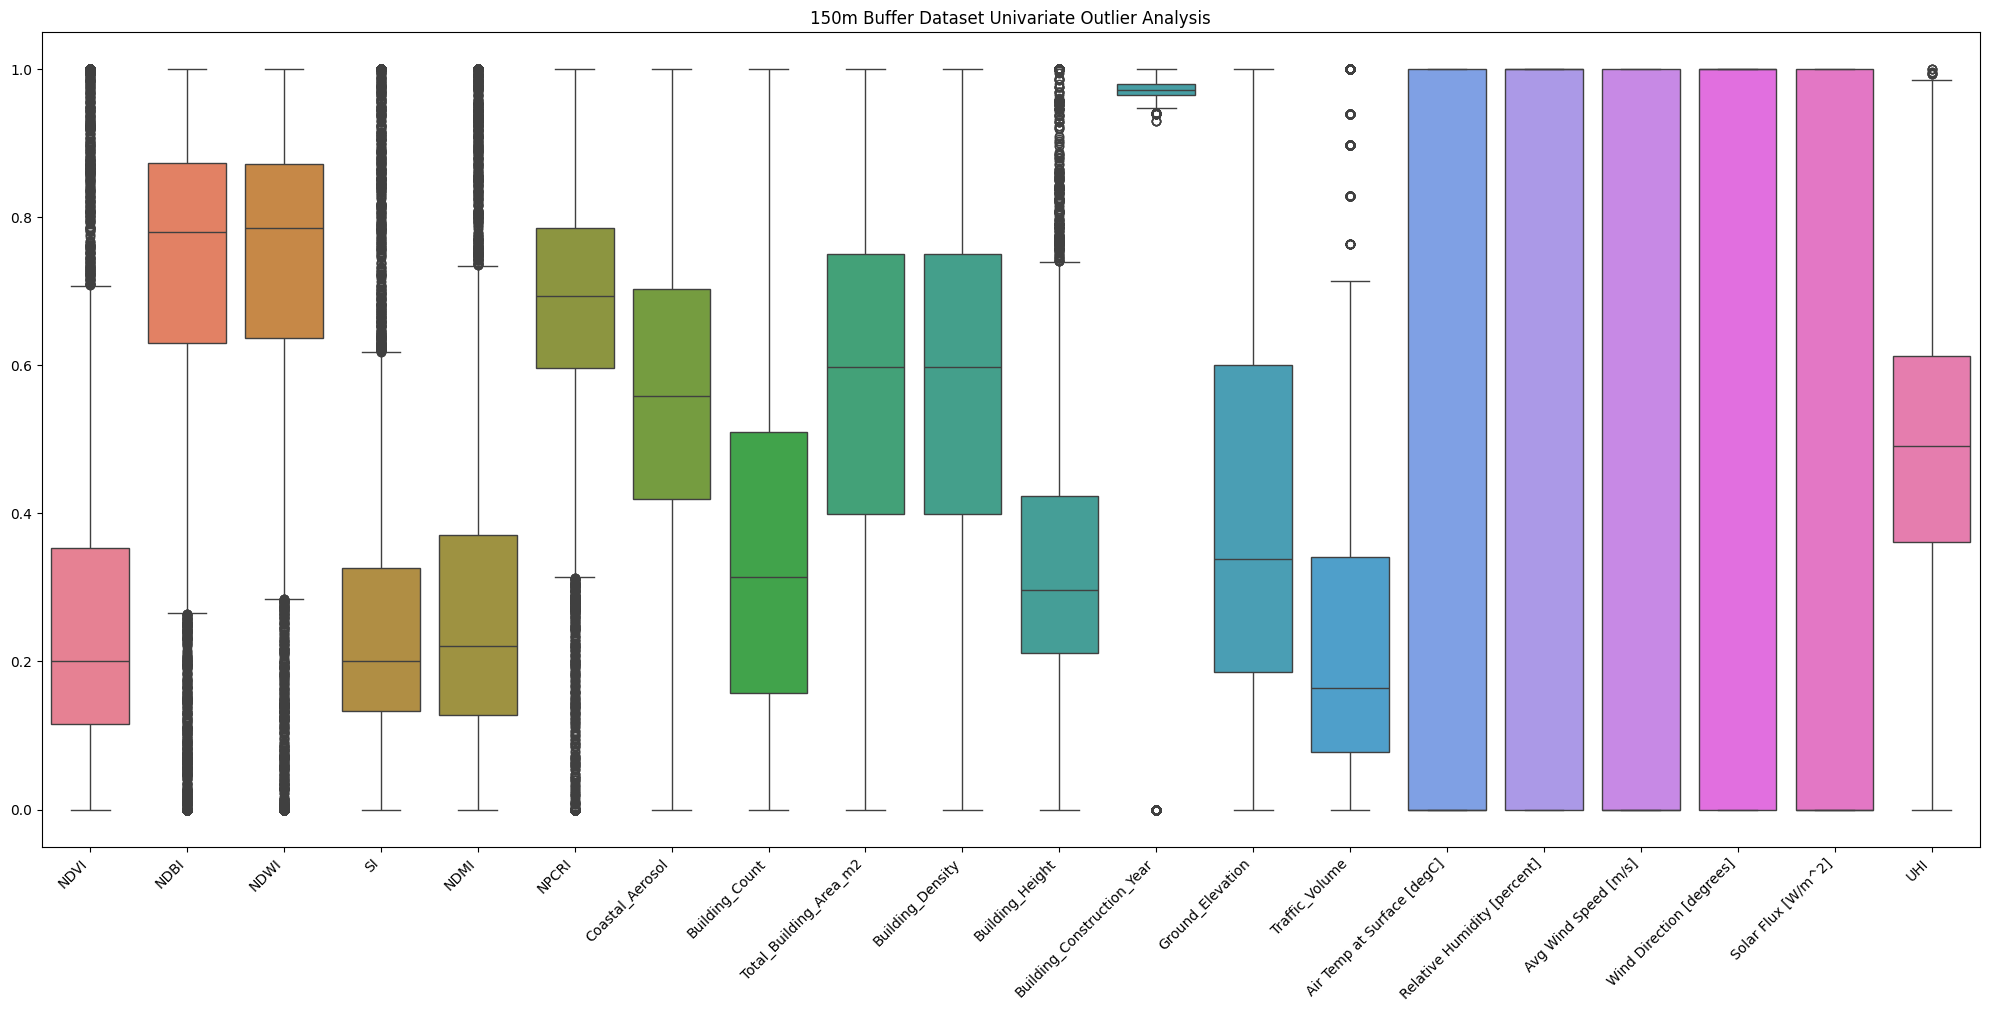

In [10]:
univariate_outlier_analysis(dataset, "150m Buffer Dataset")

We can see in the second graph that outliers in Coastal Aerosal, Building Count, Building Area, and Building Density were eliminated. All other features are skewed so we will now fix this.

>NOTE: Eliminating the outliers slightly decreased the accuracy  of model, but not by a lot.

## Eliminating Skewness

Here we will apply `boxcox` to the features that are skewed. To quantify skewness we will use `skew` from scipy.

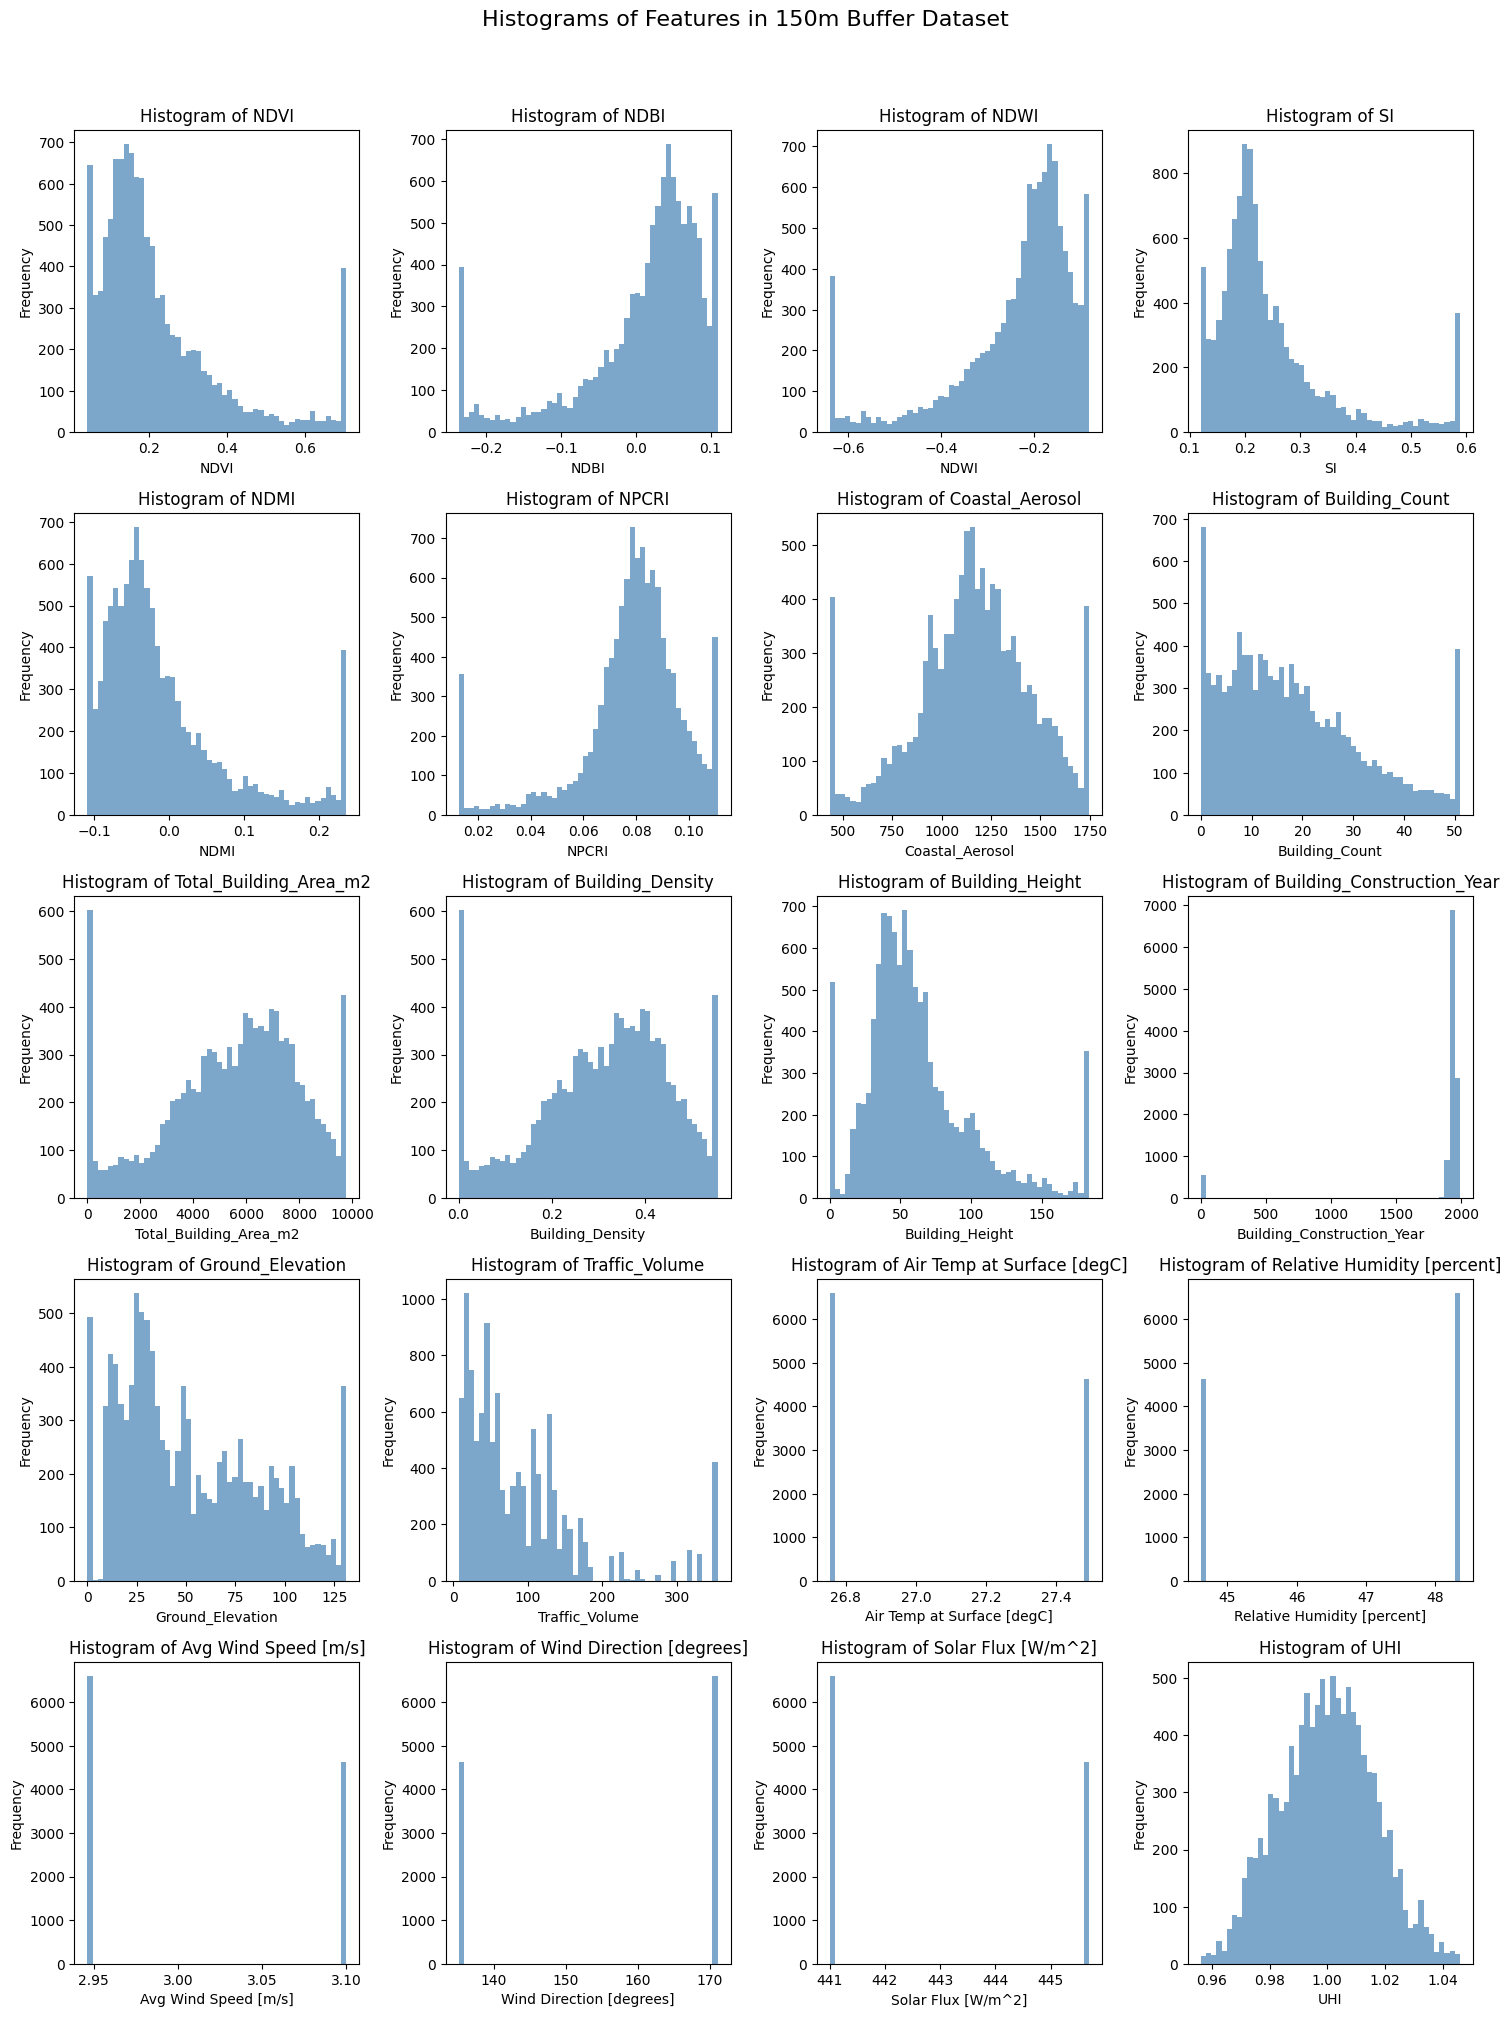

Skewness:
NDVI 1.5607059107394812
NDBI -1.4276861195444985
NDWI -1.5009704793919867
SI 1.7344832037948257
NDMI 1.4276861195444985
NPCRI -1.3107458996356212
Coastal_Aerosol -0.32656200536525254
Building_Count 0.7461893934223518
Total_Building_Area_m2 -0.47482685133077573
Building_Density -0.4748268513302392
Building_Height 1.2168055059904561
Building_Construction_Year -4.195830051926251
Ground_Elevation 0.5486151495275056
Traffic_Volume 1.7380061916817484
Air Temp at Surface [degC] 0.35696492405418956
Relative Humidity [percent] -0.3569649240542103
Avg Wind Speed [m/s] 0.3569649240541931
Wind Direction [degrees] -0.3569649240542005
Solar Flux [W/m^2] 0.35696492405417385
UHI 0.02547868830397157


In [11]:
plt = plot_all_histograms(dataset, "150m Buffer Dataset")
plt.show()
print("Skewness:")
for col in dataset.columns:
    print(col, skew(dataset[col]))

Here we can see what variables are skewed (ex; NDBI) and the skew score. To determine which features will receive the `boxcox` transformation we will use a skewness threshold.

In [12]:
SKEW_THRESHOLD=0.70

Apply the transformation.

In [13]:
dataset = apply_boxcox_transformation(dataset, SKEW_THRESHOLD)

Now, let's see the distributions again.

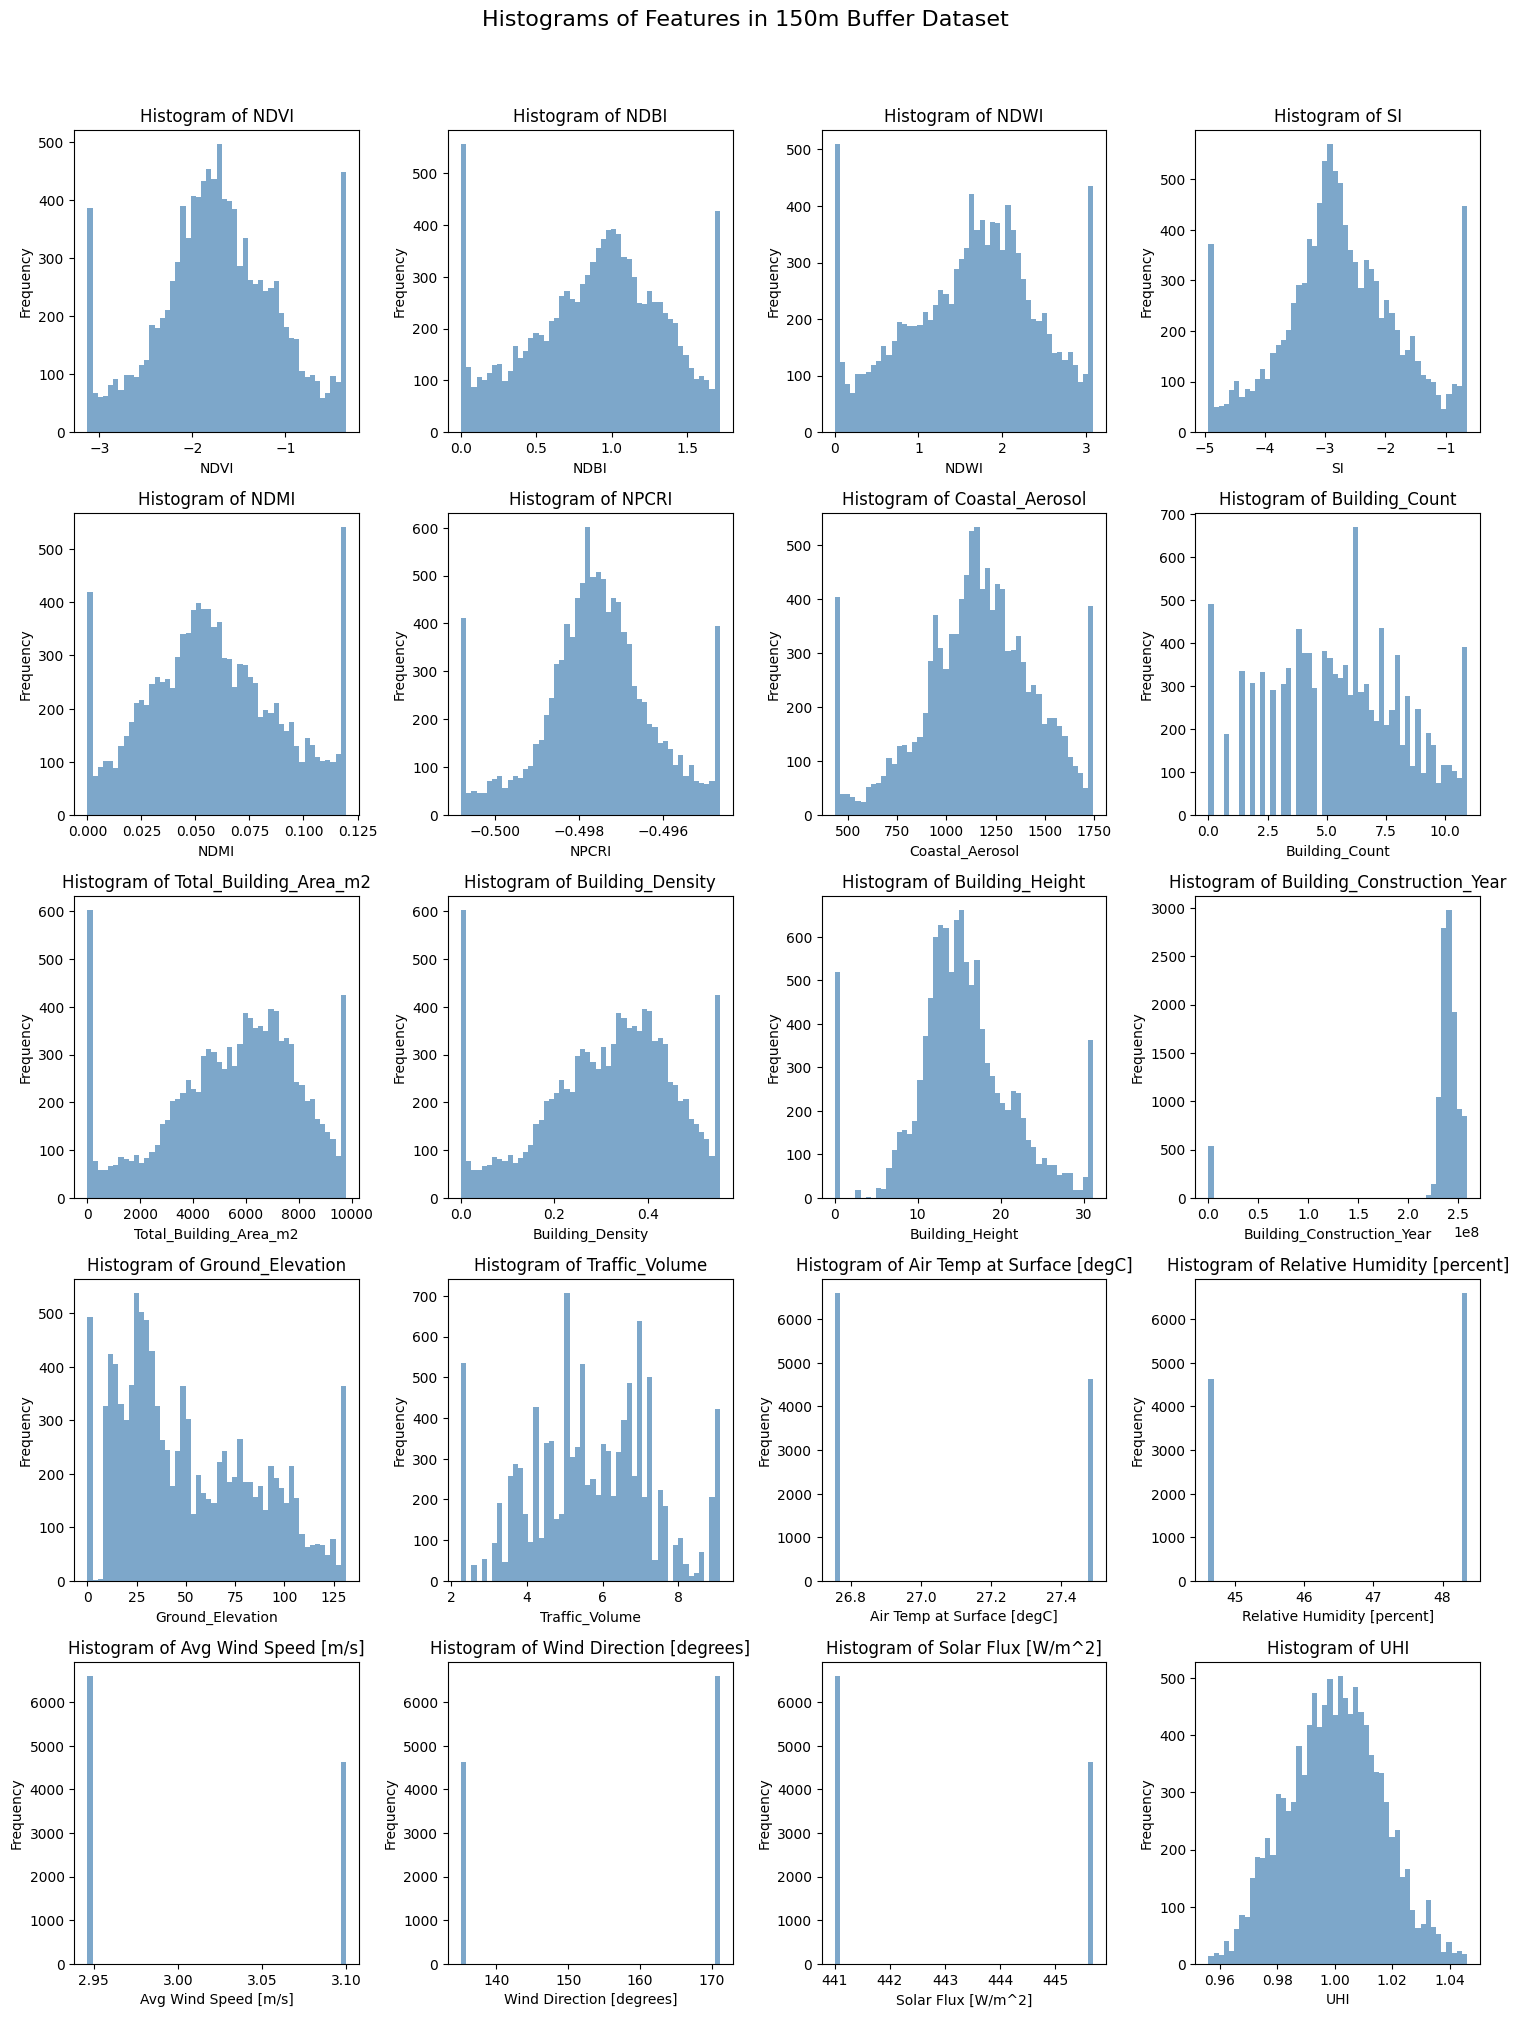

Skewness:
NDVI -0.0005829657420340314
NDBI -0.22708545838560346
NDWI -0.23901873081337924
SI 0.01814536399569054
NDMI 0.15298137622943372
NPCRI -0.15784719812800335
Coastal_Aerosol -0.32656200536525254
Building_Count -0.09586354505650399
Total_Building_Area_m2 -0.47482685133077573
Building_Density -0.4748268513302392
Building_Height 0.07471447745074554
Building_Construction_Year -4.076943931897217
Ground_Elevation 0.5486151495275056
Traffic_Volume -0.0180698687582296
Air Temp at Surface [degC] 0.35696492405418956
Relative Humidity [percent] -0.3569649240542103
Avg Wind Speed [m/s] 0.3569649240541931
Wind Direction [degrees] -0.3569649240542005
Solar Flux [W/m^2] 0.35696492405417385
UHI 0.02547868830397157


In [14]:
plt = plot_all_histograms(dataset, "150m Buffer Dataset")
plt.show()
print("Skewness:")
for col in dataset.columns:
    print(col, skew(dataset[col]))

We can see in the second graph that a lot of the features that were skewed are not skewed anymore.

>NOTE: Eliminating the outliers slightly decreased the accuracy  of model, but not by a lot.

## Applying SMOGN

In our EDA analysis we noticed that extremes could be represented better. Here, we will do that using [SMOGN](https://proceedings.mlr.press/v74/branco17a/branco17a.pdf). **Synthetic Minority Oversampling for Regression with Gaussian Noise (SMOGN)** is an oversampling technique for continous variables. It is very similiar to SMOTE. We will use the manual setting to determine the area of relevance for the SMOGN algorithm.

In [15]:
# Define relevance area
rel_ctrl_pts_rg = np.array([
    [min(dataset["UHI"]), 1, 0],  # Extreme low UHI → HIGH relevance
    [0.98, 0, 0],                 # Lower common UHI → LOW relevance
    [1.00, 0, 0],                 # Mean UHI → LOWEST relevance
    [1.02, 0, 0],                 # Upper common UHI → LOW relevance
    [max(dataset["UHI"]), 1, 0]   # Extreme high UHI → HIGH relevance
])

print("Relevance Control Points (rel_ctrl_pts_rg):")
print(rel_ctrl_pts_rg)

Relevance Control Points (rel_ctrl_pts_rg):
[[0.95612157 1.         0.        ]
 [0.98       0.         0.        ]
 [1.         0.         0.        ]
 [1.02       0.         0.        ]
 [1.04603594 1.         0.        ]]


Now, we will apply SMOGN.

In [16]:
# Apply SMOGN to the dataset
df_resampled = smogn.smoter(
    data=dataset,         # Input dataset
    y="UHI",              # Target column (continuous variable)
    samp_method="balance", # If 'extreme' is specified, more over/under-sampling is conducted
    rel_thres=0.5,        # Threshold for minority class
    rel_method="manual",    # use the manual setting this time
    rel_ctrl_pts_rg=rel_ctrl_pts_rg, # apply the manual relevance area
    pert = 0.01,
)

r_index: 100%|##########| 98/98 [00:00<00:00, 640.82it/s]


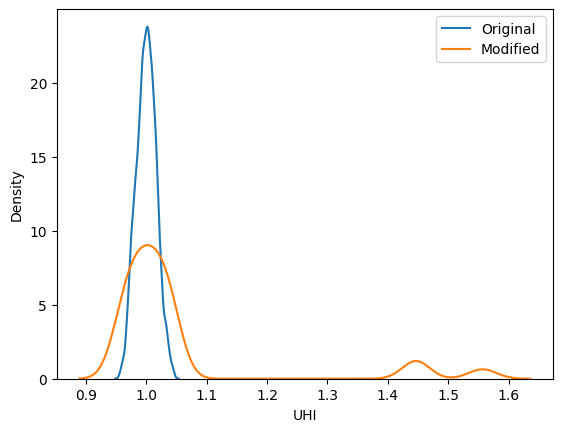

In [17]:
## plot y distribution
sns.kdeplot(dataset['UHI'], label = "Original")
sns.kdeplot(df_resampled['UHI'], label = "Modified")
plt.legend()
plt.show()

Here we see SMOGN is generating points out of range. We will clip these because it will cause our models to perform worse since they are outliers.

In [18]:
df_resampled["UHI"] = df_resampled["UHI"].clip(lower=dataset["UHI"].min(), upper=dataset["UHI"].max())

We will plot the distribution again.

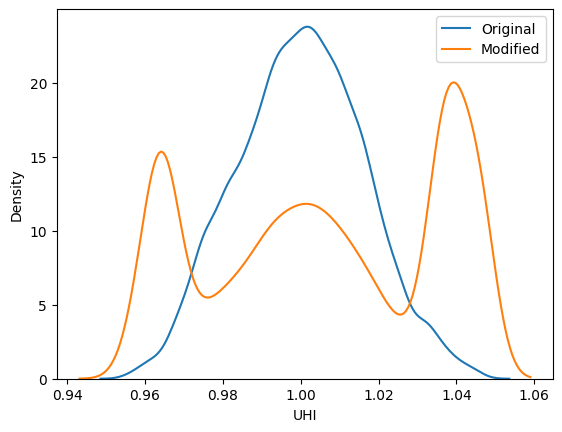

In [19]:
## plot y distribution
sns.kdeplot(dataset['UHI'], label = "Original")
sns.kdeplot(df_resampled['UHI'], label = "Modified")
plt.legend()
plt.show()

Here we see SMOGN over-sampled "minority" values and under-sampled "majority" values in UHI. This will help our models learn the relationships at the extremes.

>NOTE: SMOGN did not help in improving the model. It was generating way too much minority values.

## Feature Engineering

>TODO: try combining some features

# Evaluating the Preprocessed data

In [26]:
preprocessed_dataset = dataset.copy()

# Split the data into features (X) and target (y), and then into training and validation sets
x = preprocessed_dataset.drop(columns=['UHI']).values
y = preprocessed_dataset['UHI'].values
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y,
    test_size=VALID_SPLIT,
    random_state=RANDOM_STATE)
fiftym_x_names = list(preprocessed_dataset.drop(columns=['UHI']).columns)

# Scale the training and validation data using standardscaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

# Train the Random Forest model on the training data
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    criterion="squared_error")
rf_model.fit(x_train, y_train)

# Make predictions on the training data
insample_predictions = rf_model.predict(x_train)

# calculate R-squared score for in-sample predictions
print(f"In-Sample Evaluation:")
insample_r2 = r2_score(y_train, insample_predictions)
print(f"  R-squared: {insample_r2}")

# Make predictions on the validation data
out_of_sample_predictions = rf_model.predict(x_valid)

# calculate R-squared score for out-sample predictions
print(f"Out-Of-Sample Evaluation:")
out_of_sample_r2 = r2_score(y_valid, out_of_sample_predictions)
print(f"  R-squared: {out_of_sample_r2}")

In-Sample Evaluation:
  R-squared: 0.9901141838318012
Out-Of-Sample Evaluation:
  R-squared: 0.9294511532247621


In [27]:
from sklearn.preprocessing import PolynomialFeatures

# Define the interaction transformer (degree=2 for pairwise interactions only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Apply to the feature set
x_interactions = poly.fit_transform(x)

# Get new feature names
interaction_feature_names = poly.get_feature_names_out(preprocessed_dataset.drop(columns=['UHI']).columns)

# Convert to DataFrame
x_interactions_df = pd.DataFrame(x_interactions, columns=interaction_feature_names)

# Add target variable back
preprocessed_dataset_interactions = x_interactions_df.copy()
preprocessed_dataset_interactions["UHI"] = y

In [28]:
# Split the new dataset into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    preprocessed_dataset_interactions.drop(columns=["UHI"]).values,
    preprocessed_dataset_interactions["UHI"].values,
    test_size=VALID_SPLIT,
    random_state=RANDOM_STATE
)

# Scale the data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

# Train the Random Forest model on the training data
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    criterion="squared_error")
rf_model.fit(x_train, y_train)

# Make Predictions & Evaluate
print("In-Sample R-squared:", r2_score(y_train, rf_model.predict(x_train)))
print("Out-of-Sample R-squared:", r2_score(y_valid, rf_model.predict(x_valid)))

In-Sample R-squared: 0.9892743252452316
Out-of-Sample R-squared: 0.9245578970750592


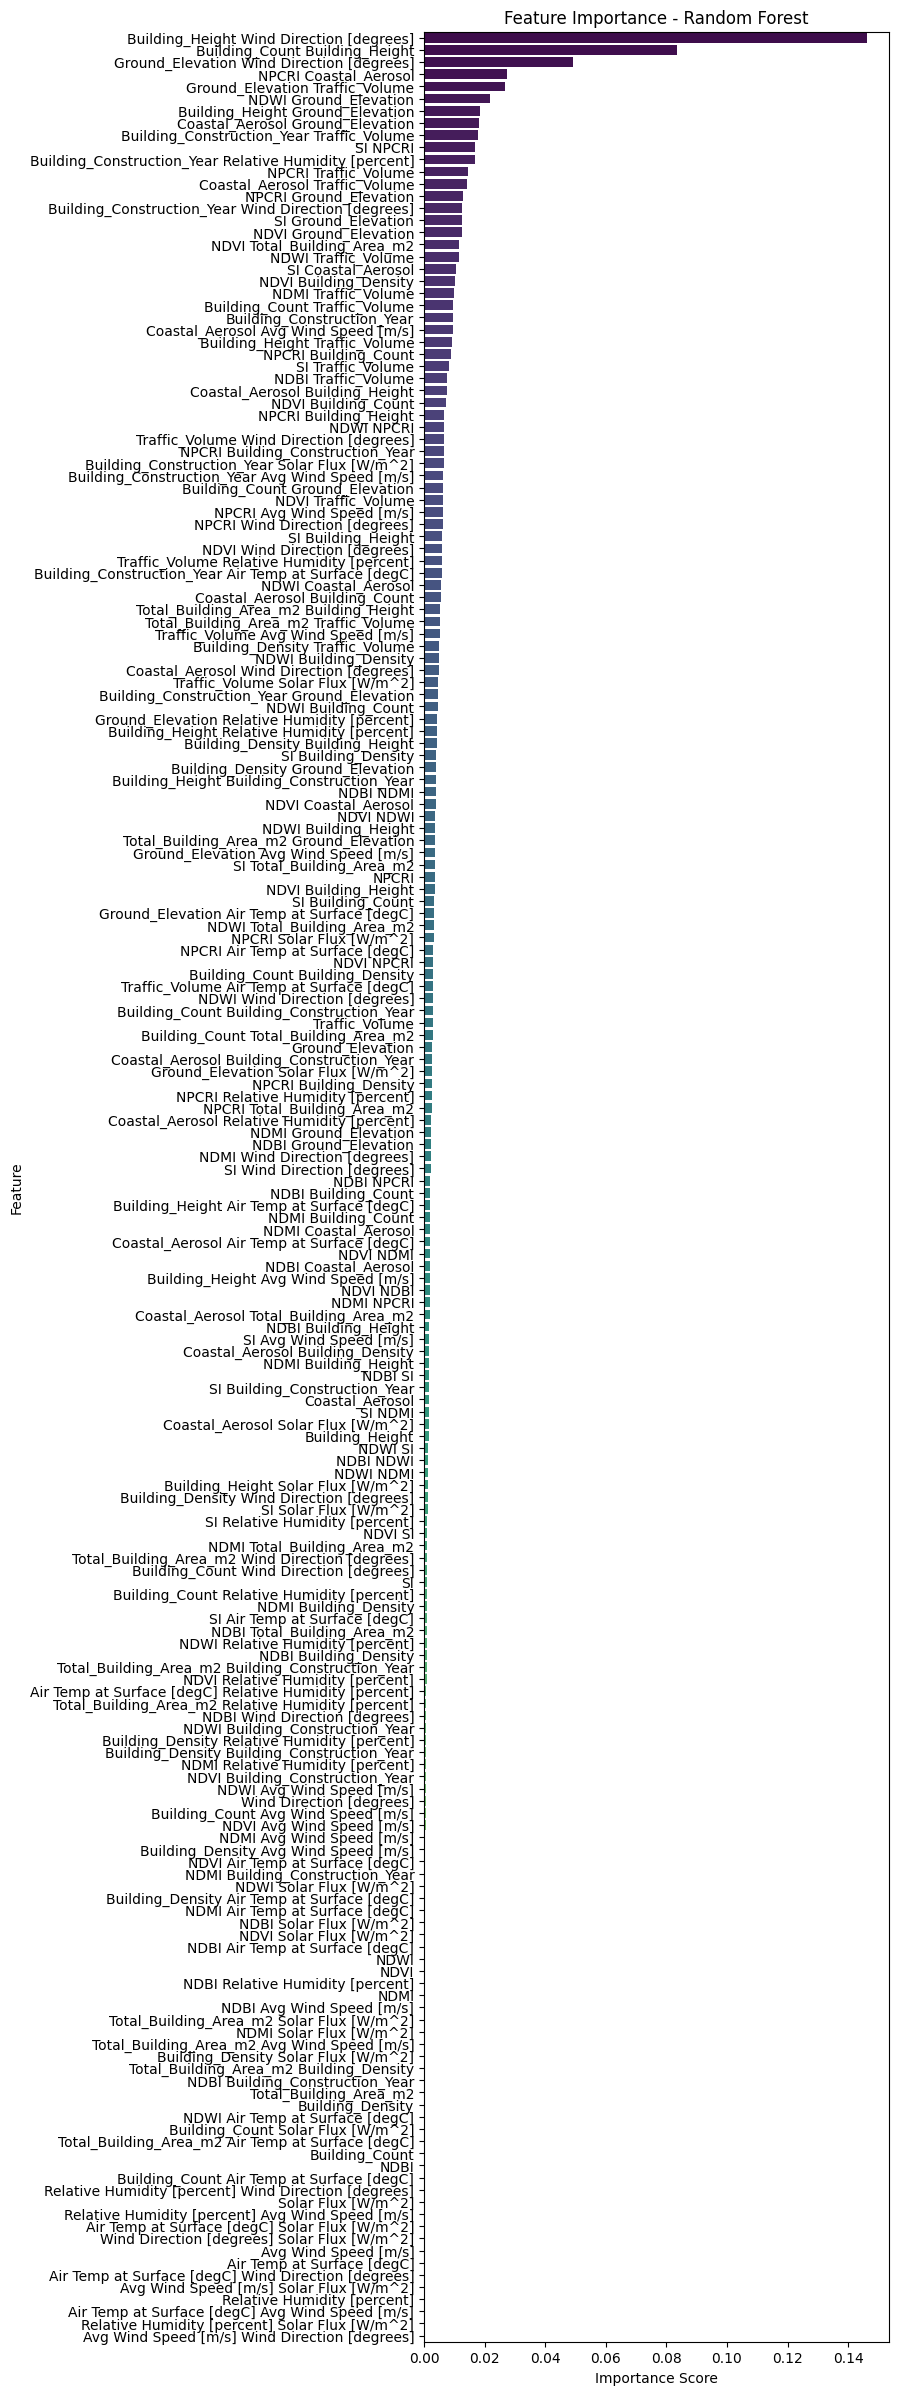

In [37]:
# Get feature importance
feature_importance = rf_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': interaction_feature_names,  # Use feature names
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(6, 30))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

>TODO: Use the proprocessed data on the simple random forest regressor model to evaluate it.

# Conclusion

>TODO: Create the function that will apply everything in this notebook to the dataset that is passed through. Make the function capable of modifying the data pipeline, basically the function is able to not do a preprocessing step if the user does not want it. To do this make each section in this notebook a function, then in the preprocessing function the user can pass in the individual functions to apply them.

>TODO: copy all helper functions to tools.preprocess